In [1]:
#PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np

#dataset
import torch.utils.data as utils

#For paths
import glob

#imread
from skimage import io, transform

#split dataset
from sklearn.model_selection import train_test_split

#Timestamp
import datetime

In [2]:
root_path = "D:/Downloads/kinect_leap_dataset/acquisitions"
p_id = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10", "P11", "P12", "P13", "P14"]
g_id = ["G1", "G2", "G3", "G4", "G5", "G6", "G7", "G8", "G9", "G10"]

In [3]:
print(root_path + "/P1/G1")
files = glob.glob(root_path + "/P1/G1/" + "*depth.png")
print(files)
print(len(files))

D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1
['D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\10_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\1_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\2_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\3_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\4_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\5_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\6_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\7_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\8_depth.png', 'D:/Downloads/kinect_leap_dataset/acquisitions/P1/G1\\9_depth.png']
10


In [4]:
dataset = []
labels = []

for p in p_id:
    for g in g_id:
        #print(p, g)
        image_names = glob.glob(root_path + "/" +  p + "/" + g + "/" + "*depth.png")
        for img_path in image_names:
            img = io.imread(img_path)
            img = transform.rescale(img, 1.0 / 4.0)
            
            img = np.resize(img,(1,120,160))
            
            dataset.append(img)
            
            #label 10 will be 0
            tmp = np.zeros(10)
            tmp[int(g[-1])] = 1
            labels.append(tmp)
            #labels.append(int(g[-1]))

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
#ffs
dataset = np.array(dataset).astype(float)
labels = np.array(labels).astype(float)

In [6]:
print(type(labels))
print(type(dataset))
X_train, X_test_val, y_train, y_test_val = train_test_split(dataset, labels, test_size=0.2)
print(type(X_train))
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
dataset = torch.from_numpy(dataset).float()
labels = torch.from_numpy(labels).float()
print(type(dataset))
print(type(labels))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [8]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

In [9]:
my_dataset = utils.TensorDataset(dataset, labels) # create your dataset
my_dataloader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

In [10]:
my_dataset = utils.TensorDataset(X_train, y_train) # create your dataset
train_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

my_dataset = utils.TensorDataset(X_val, y_val) # create your dataset
val_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

my_dataset = utils.TensorDataset(X_test, y_test) # create your dataset
test_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

In [11]:
#input 640x480
#h=480, w=640
#downscaled by 4

#output 10 classes
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(16 * 37 * 27, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        #print(list(x.size()))
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        #print(list(x.size()))
        
        #x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        #print(list(x.size()))
        x = x.view(-1, self.num_flat_features(x))
        
        #print(list(x.size()))
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [12]:
model = Net()
print(model)
#if torch.cuda.is_available():
#    net.cuda()

criterion = torch.nn.MSELoss(size_average=False)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=15984, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
'''#my_dataset
#my_dataloader
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(my_dataloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = Variable(inputs)
        inputs = inputs.float()
        labels = Variable(labels)
        labels = labels.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')'''

"#my_dataset\n#my_dataloader\nfor epoch in range(2):  # loop over the dataset multiple times\n    running_loss = 0.0\n    for i, data in enumerate(my_dataloader, 0):\n        # get the inputs\n        inputs, labels = data\n        inputs = Variable(inputs)\n        inputs = inputs.float()\n        labels = Variable(labels)\n        labels = labels.float()\n        \n        # zero the parameter gradients\n        optimizer.zero_grad()\n\n        # forward + backward + optimize\n        outputs = net(inputs)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n\n        # print statistics\n        running_loss += loss.item()\n        if i % 2000 == 1999:    # print every 2000 mini-batches\n            print('[%d, %5d] loss: %.3f' %\n                  (epoch + 1, i + 1, running_loss / 2000))\n            running_loss = 0.0\n\nprint('Finished Training')"

In [14]:
#my_dataset
#my_dataloader

train_loss_history = []
train_acc_history = []
val_acc_history = []
val_loss_history = []
num_epochs = 100
iter_per_epoch = len(train_loader)
#224 lines -> 112 val output for log_nth=10000
#1120000 iter
log_nth = 16

if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):  # loop over the dataset multiple times
    for i, (inputs, targets) in enumerate(train_loader, 1):
        inputs, targets = Variable(inputs.float()), Variable(targets.float())
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss_history.append(loss.data.cpu().numpy())
        if log_nth and i % log_nth == 0:
            last_log_nth_losses = train_loss_history[-log_nth:]
            train_loss = np.mean(last_log_nth_losses)
            print('[Iteration %d/%d] TRAIN loss: %.3f' % \
                        (i + epoch * iter_per_epoch,
                         iter_per_epoch * num_epochs,
                         train_loss))
            
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    #print(preds)
    #print(targets)
    train_acc = np.mean((preds == target_indices).data.cpu().numpy())
    train_acc_history.append(train_acc)
    if log_nth:
        print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1,
                                                            num_epochs,
                                                            train_acc,
                                                            loss))
        '''_, preds = torch.max(outputs, 1)

        # Only allow images/pixels with label >= 0 e.g. for segmentation
        targets_mask = labels >= 0
        train_acc = np.mean((preds == targets)[targets_mask].data.cpu().numpy())
        train_acc_history.append(train_acc)
        if log_nth:
            print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1,
                                                                   num_epochs,
                                                                   train_acc,
                                                                   train_loss))'''
        
    # VALIDATION
    val_losses = []
    val_scores = []
    model.eval()
    for inputs, targets in val_loader:
        inputs, targets = Variable(inputs), Variable(targets)
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model.forward(inputs)
        loss = criterion(outputs, targets)
        val_losses.append(loss.data.cpu().numpy())

        _, preds = torch.max(outputs, 1)
        _, target_indices = torch.max(targets, 1)

        scores = np.mean((preds == target_indices).data.cpu().numpy())
        val_scores.append(scores)

    model.train()
    val_acc, val_loss = np.mean(val_scores), np.mean(val_losses)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    if log_nth:
        print('[Epoch %d/%d] VAL   acc/loss: %.3f/%.3f' % (epoch + 1,
                                                            num_epochs,
                                                            val_acc,
                                                            val_loss))

print('Finished Training')

[Iteration 16/11200] TRAIN loss: 9.634
[Iteration 32/11200] TRAIN loss: 9.109
[Iteration 48/11200] TRAIN loss: 9.061
[Iteration 64/11200] TRAIN loss: 9.048
[Iteration 80/11200] TRAIN loss: 9.011
[Iteration 96/11200] TRAIN loss: 8.979
[Iteration 112/11200] TRAIN loss: 8.998
[Epoch 1/100] TRAIN acc/loss: 0.100/8.971
[Epoch 1/100] VAL   acc/loss: 0.086/9.023
[Iteration 128/11200] TRAIN loss: 8.909
[Iteration 144/11200] TRAIN loss: 8.917
[Iteration 160/11200] TRAIN loss: 8.924
[Iteration 176/11200] TRAIN loss: 8.922
[Iteration 192/11200] TRAIN loss: 8.975
[Iteration 208/11200] TRAIN loss: 8.885
[Iteration 224/11200] TRAIN loss: 8.799
[Epoch 2/100] TRAIN acc/loss: 0.200/8.729
[Epoch 2/100] VAL   acc/loss: 0.079/9.058
[Iteration 240/11200] TRAIN loss: 8.759
[Iteration 256/11200] TRAIN loss: 8.844
[Iteration 272/11200] TRAIN loss: 8.803
[Iteration 288/11200] TRAIN loss: 8.748
[Iteration 304/11200] TRAIN loss: 8.693
[Iteration 320/11200] TRAIN loss: 8.643
[Iteration 336/11200] TRAIN loss: 8.67

[Iteration 2512/11200] TRAIN loss: 2.440
[Iteration 2528/11200] TRAIN loss: 2.339
[Iteration 2544/11200] TRAIN loss: 2.150
[Iteration 2560/11200] TRAIN loss: 1.984
[Iteration 2576/11200] TRAIN loss: 2.246
[Epoch 23/100] TRAIN acc/loss: 1.000/1.741
[Epoch 23/100] VAL   acc/loss: 0.793/4.489
[Iteration 2592/11200] TRAIN loss: 1.838
[Iteration 2608/11200] TRAIN loss: 2.114
[Iteration 2624/11200] TRAIN loss: 2.115
[Iteration 2640/11200] TRAIN loss: 1.817
[Iteration 2656/11200] TRAIN loss: 2.124
[Iteration 2672/11200] TRAIN loss: 2.199
[Iteration 2688/11200] TRAIN loss: 2.074
[Epoch 24/100] TRAIN acc/loss: 0.900/2.358
[Epoch 24/100] VAL   acc/loss: 0.786/4.542
[Iteration 2704/11200] TRAIN loss: 1.777
[Iteration 2720/11200] TRAIN loss: 1.721
[Iteration 2736/11200] TRAIN loss: 1.747
[Iteration 2752/11200] TRAIN loss: 2.025
[Iteration 2768/11200] TRAIN loss: 1.975
[Iteration 2784/11200] TRAIN loss: 2.028
[Iteration 2800/11200] TRAIN loss: 1.964
[Epoch 25/100] TRAIN acc/loss: 1.000/1.670
[Epoch

[Iteration 4976/11200] TRAIN loss: 0.342
[Iteration 4992/11200] TRAIN loss: 0.381
[Iteration 5008/11200] TRAIN loss: 0.361
[Iteration 5024/11200] TRAIN loss: 0.425
[Iteration 5040/11200] TRAIN loss: 0.381
[Epoch 45/100] TRAIN acc/loss: 1.000/0.445
[Epoch 45/100] VAL   acc/loss: 0.857/3.092
[Iteration 5056/11200] TRAIN loss: 0.302
[Iteration 5072/11200] TRAIN loss: 0.428
[Iteration 5088/11200] TRAIN loss: 0.345
[Iteration 5104/11200] TRAIN loss: 0.392
[Iteration 5120/11200] TRAIN loss: 0.335
[Iteration 5136/11200] TRAIN loss: 0.304
[Iteration 5152/11200] TRAIN loss: 0.388
[Epoch 46/100] TRAIN acc/loss: 1.000/0.481
[Epoch 46/100] VAL   acc/loss: 0.864/3.004
[Iteration 5168/11200] TRAIN loss: 0.308
[Iteration 5184/11200] TRAIN loss: 0.315
[Iteration 5200/11200] TRAIN loss: 0.323
[Iteration 5216/11200] TRAIN loss: 0.380
[Iteration 5232/11200] TRAIN loss: 0.303
[Iteration 5248/11200] TRAIN loss: 0.327
[Iteration 5264/11200] TRAIN loss: 0.348
[Epoch 47/100] TRAIN acc/loss: 1.000/0.291
[Epoch

[Iteration 7440/11200] TRAIN loss: 0.078
[Iteration 7456/11200] TRAIN loss: 0.085
[Iteration 7472/11200] TRAIN loss: 0.081
[Iteration 7488/11200] TRAIN loss: 0.079
[Iteration 7504/11200] TRAIN loss: 0.094
[Epoch 67/100] TRAIN acc/loss: 1.000/0.078
[Epoch 67/100] VAL   acc/loss: 0.886/2.673
[Iteration 7520/11200] TRAIN loss: 0.072
[Iteration 7536/11200] TRAIN loss: 0.086
[Iteration 7552/11200] TRAIN loss: 0.081
[Iteration 7568/11200] TRAIN loss: 0.084
[Iteration 7584/11200] TRAIN loss: 0.079
[Iteration 7600/11200] TRAIN loss: 0.086
[Iteration 7616/11200] TRAIN loss: 0.084
[Epoch 68/100] TRAIN acc/loss: 1.000/0.095
[Epoch 68/100] VAL   acc/loss: 0.871/2.722
[Iteration 7632/11200] TRAIN loss: 0.069
[Iteration 7648/11200] TRAIN loss: 0.072
[Iteration 7664/11200] TRAIN loss: 0.073
[Iteration 7680/11200] TRAIN loss: 0.070
[Iteration 7696/11200] TRAIN loss: 0.087
[Iteration 7712/11200] TRAIN loss: 0.078
[Iteration 7728/11200] TRAIN loss: 0.078
[Epoch 69/100] TRAIN acc/loss: 1.000/0.104
[Epoch

[Iteration 9904/11200] TRAIN loss: 0.046
[Iteration 9920/11200] TRAIN loss: 0.044
[Iteration 9936/11200] TRAIN loss: 0.050
[Iteration 9952/11200] TRAIN loss: 0.053
[Iteration 9968/11200] TRAIN loss: 0.048
[Epoch 89/100] TRAIN acc/loss: 1.000/0.067
[Epoch 89/100] VAL   acc/loss: 0.893/2.574
[Iteration 9984/11200] TRAIN loss: 0.040
[Iteration 10000/11200] TRAIN loss: 0.036
[Iteration 10016/11200] TRAIN loss: 0.039
[Iteration 10032/11200] TRAIN loss: 0.048
[Iteration 10048/11200] TRAIN loss: 0.052
[Iteration 10064/11200] TRAIN loss: 0.061
[Iteration 10080/11200] TRAIN loss: 0.059
[Epoch 90/100] TRAIN acc/loss: 1.000/0.046
[Epoch 90/100] VAL   acc/loss: 0.879/2.622
[Iteration 10096/11200] TRAIN loss: 0.048
[Iteration 10112/11200] TRAIN loss: 0.047
[Iteration 10128/11200] TRAIN loss: 0.044
[Iteration 10144/11200] TRAIN loss: 0.040
[Iteration 10160/11200] TRAIN loss: 0.045
[Iteration 10176/11200] TRAIN loss: 0.053
[Iteration 10192/11200] TRAIN loss: 0.053
[Epoch 91/100] TRAIN acc/loss: 1.000

In [15]:
params = list(model.parameters())

In [16]:
currentDT = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = "models/lenet_depth_" + str(num_epochs) + "_" + currentDT + ".model"
torch.save(model, path)

C:\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:
#80% -> 10 epochs
#87% -> 50 epochs

scores = []
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    scores.extend((preds == target_indices).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))

Test set accuracy: 0.878571


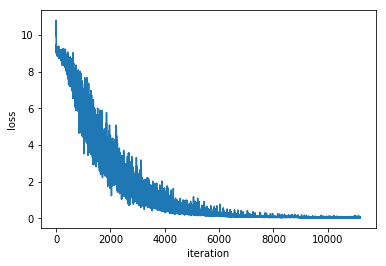

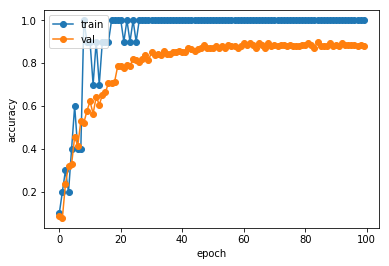

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, '-')
#plt.plot(val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [19]:
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    scores.extend((preds == target_indices).data.cpu().numpy())

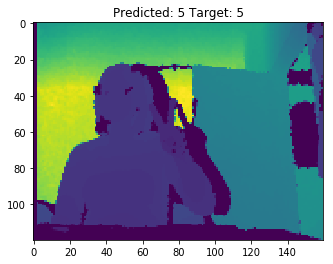

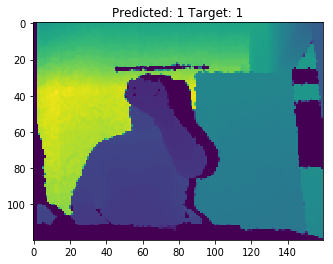

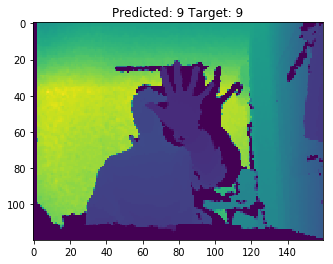

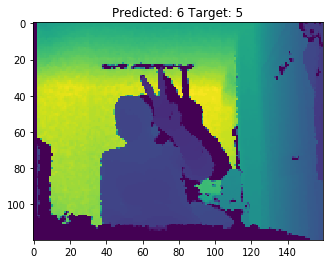

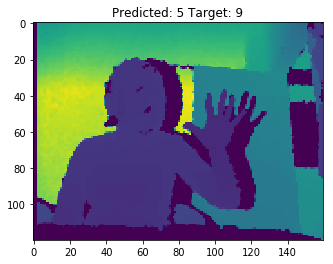

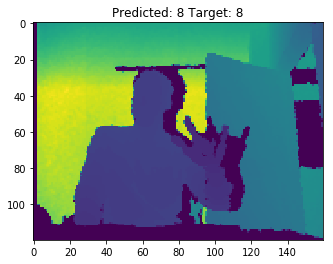

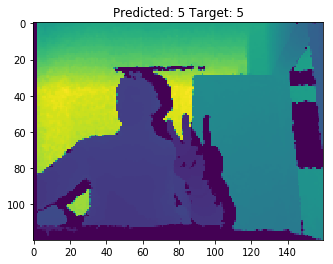

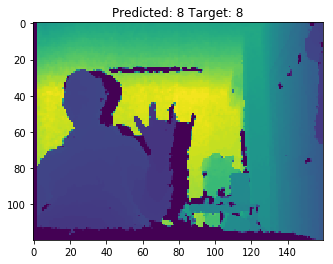

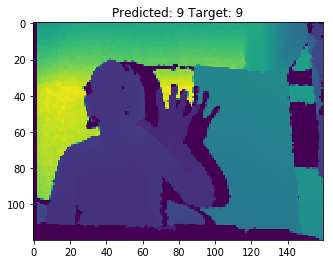

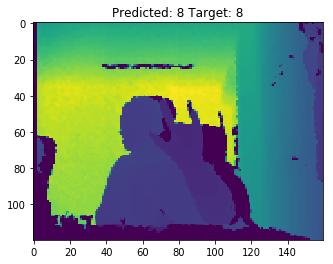

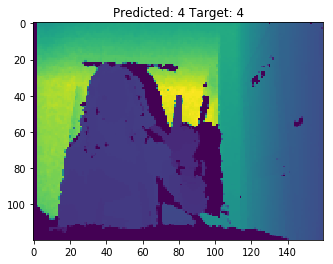

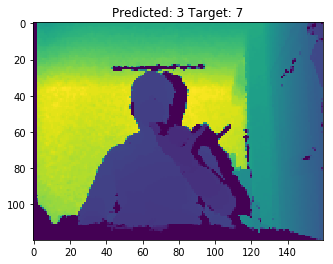

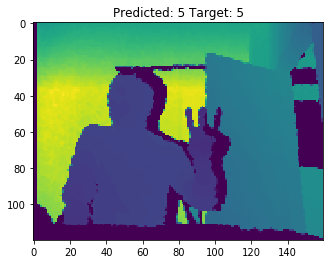

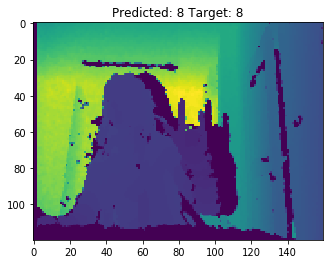

In [21]:
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    
    numpy_inputs = inputs.data.cpu().numpy()
    numpy_outputs = outputs.data.cpu().numpy()
    numpy_targets = targets.data.cpu().numpy()
    
    img = numpy_inputs[0]
    img = img[0, :, :]
    plt.imshow(img)
    plt.title("Predicted: "+str(preds[0].item()) + " Target: "+str(target_indices[0].item()))
    plt.show()
    #currentDT = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    #path = "images/img_" + currentDT + ".png"
    #plt.imsave(path, img.astype(float))